AdaBoost algorithm, short for Adaptive Boosting, is a Boosting technique used as an Ensemble Method in Machine Learning. It is called Adaptive Boosting as the weights are re-assigned to each instance, with higher weights assigned to incorrectly classified instances.

In [2]:
from numpy import *

def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [3]:
datMat,classLabels = loadSimpData()

In [31]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
         
        labelMat.append(float(curLine[-1]))
        #dataMat = dataMat.astype(float)
        
    
    return dataMat,labelMat



In [5]:
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = ones((shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

In [6]:
def buildStump(dataArr,classLabels,D):
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
    minError = inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                #Line where AdaBoost interacts with the classifier.
                weightedError = D.T*errArr  #calc total error multiplied by D
                #print ("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst
    

In [7]:
D = mat(ones((5,1))/5)

In [8]:
buildStump(datMat,classLabels,D)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

Implementing the full AdaBoost algorithm

In [38]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    #mis the number of datapoints in a dataset
    m = shape(dataArr)[0]
    #D holds all the weights of each peice of data
    D = mat(ones((m,1))/m)   #init D to all equal
    #aggregrate estimate of the class for every data point
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        print("D:",D.T)
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        print ("classEst: ",classEst.T)
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        print ("aggClassEst: ",aggClassEst.T)
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        print ("total error: ",errorRate)
        if errorRate == 0.0: break
    return weakClassArr ,aggClassEst

In [39]:
classifierArray = adaBoostTrainDS(datMat,classLabels,9)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0


In [40]:
classifierArray

([{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
  {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
  {'alpha': 0.8958797346140273, 'dim': 0, 'ineq': 'lt', 'thresh': 0.9}],
 matrix([[ 1.17568763],
         [ 2.56198199],
         [-0.77022252],
         [-0.77022252],
         [ 0.61607184]]))

In [41]:
def adaClassify(datToClass,classifierArr):
    dataMatrix = mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst =stumpClassify(dataMatrix,classifierArr[i]['dim'],
                                 classifierArr[i]['thresh'],
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        print (aggClassEst)
    return sign(aggClassEst)

In [42]:
import pandas as pd

testFile = "horseColicTraining2.txt"
train = pd.read_csv(testFile, sep='\t',header=0,encoding='windows-1252')
print(train)
#https://drive.google.com/file/d/1yZy2zDu-FjfyoUBVG9Wde9n3SCJYoaFo/view?usp=sharing

     2.000000  1.000000  38.500000  ...  0.000000.4  0.000000.5  -1.000000
0         1.0       1.0       39.2  ...         2.0         2.0       -1.0
1         2.0       1.0       38.3  ...         0.0         0.0        1.0
2         1.0       9.0       39.1  ...         3.0         5.3       -1.0
3         2.0       1.0       37.3  ...         0.0         0.0       -1.0
4         2.0       1.0        0.0  ...         0.0         0.0        1.0
..        ...       ...        ...  ...         ...         ...        ...
293       1.0       1.0        0.0  ...         0.0         0.0       -1.0
294       2.0       1.0       37.2  ...         3.0         3.3       -1.0
295       1.0       1.0       37.5  ...         0.0         0.0       -1.0
296       1.0       1.0       36.5  ...         3.0         3.4        1.0
297       1.0       1.0       37.2  ...         1.0         1.0       -1.0

[298 rows x 22 columns]


In [43]:
datArr,labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray = adaBoostTrainDS(datArr,labelArr,10)

D: [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448

In [48]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    %matplotlib inline
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print ("the Area Under the Curve is: ",ySum*xStep)

In [49]:
datArr,labelArr = loadDataSet('horseColicTraining2.txt')

In [50]:
classifierArray,aggClassEst = adaBoostTrainDS(datArr,labelArr,10)

D: [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448

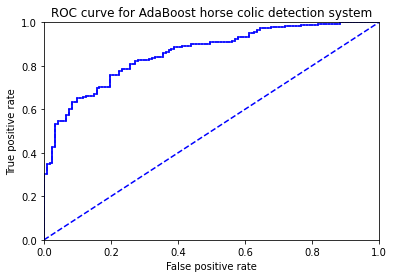

the Area Under the Curve is:  0.8582969635063604


In [51]:
plotROC(aggClassEst.T,labelArr)

The area under the curve is: 0.8582969635063604